In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

## Preprocessing

In [2]:
data = pd.read_csv("data/train.csv")
data.drop("Id", axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Identify columns with too many missings (above 25%); missings may be non-random

In [3]:
missings = pd.DataFrame({"column": data.columns, "missing": data.isnull().sum() / len(data)}).sort_values("missing", ascending=False).reset_index(drop=True)
too_many_missings = missings[missings["missing"] > 0.25]["column"].tolist()

Looking at distributions:

<Axes: xlabel='SalePrice', ylabel='Count'>

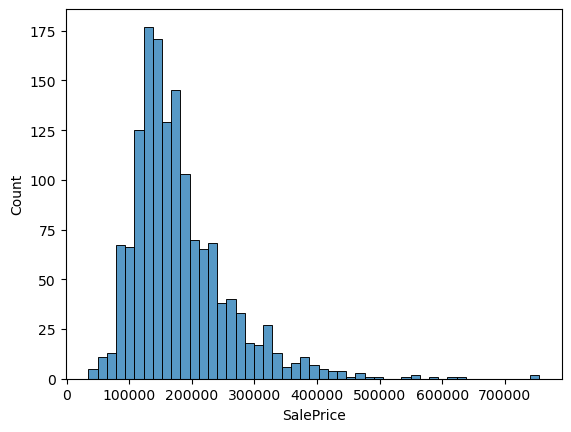

In [4]:
sns.histplot(data["SalePrice"]) # target

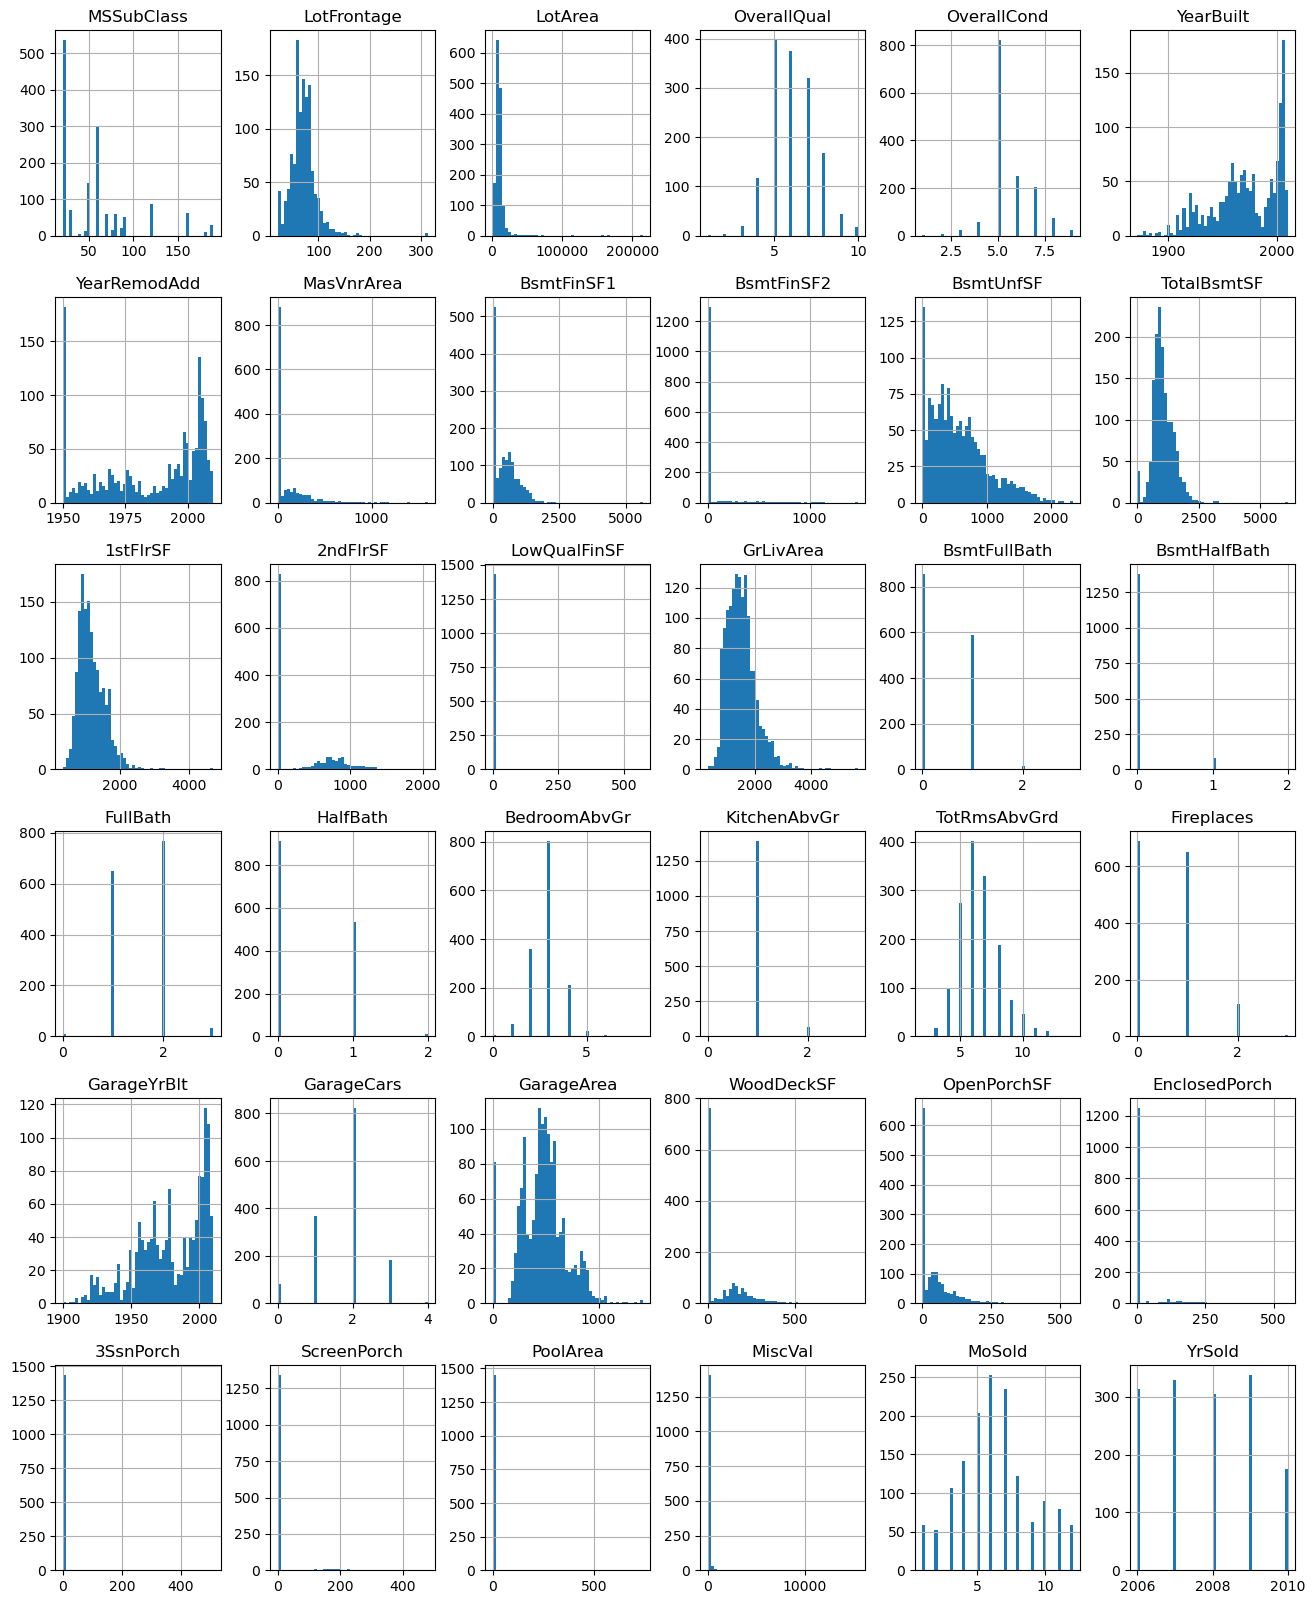

In [5]:
data.select_dtypes(include="number").drop("SalePrice", axis=1).hist(figsize=(16, 20), bins=50);

In [6]:
log_features = ["1stFlrSF", "GrLivArea", "LotFrontage"] # based on visually inspecting distributions

Categorical features (for one-hot encoding):

In [7]:
categorical = data.select_dtypes(include="object").columns.tolist()
#data = pd.get_dummies(data, columns=categorical, dtype=int)

While this is not neccessary for XGBoost, which can work with categorical inputs, it is neccessary for model-based imputation (Bayesian Ridge Regression only works with numeric inputs afaik).

Define target and features:

In [8]:
target = "SalePrice"
features = data.drop(target, axis=1).columns.tolist()

Prep-pipeline; no normalization needed for XGBoost (tree-based):

In [9]:
dropper = FunctionTransformer(func=lambda X: X.drop(too_many_missings, axis=1))

one_hot_encoder = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical)
    ],
    remainder='passthrough'  # Keep other columns (numerical ones) unchanged
)

log_transformer = FunctionTransformer(func=lambda X: X.assign(**{col: np.log1p(X[col]) for col in log_features}))

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('drop', dropper, too_many_missings),  # Dropping features
        ('log', log_transformer, log_features),  # Log transformation
        ('onehot', one_hot_encoder, categorical)  # One-hot encoding
    ],
    remainder='passthrough'  # Leave the rest of the features untouched
)

# Final pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('imputation', IterativeImputer(estimator=BayesianRidge(), random_state=42, verbose=2,  max_iter=100))
])

In [10]:
X = pipeline.fit_transform(data[features])

[IterativeImputer] Completing matrix with shape (1460, 303)
[IterativeImputer] Ending imputation round 1/100, elapsed time 27.93
[IterativeImputer] Change: 168.30866685153168, scaled tolerance: 215.245 
[IterativeImputer] Early stopping criterion reached.


In [11]:
y = np.log1p(data[target])

## Model

In [14]:
def collect_metrics(y: np.array, y_hat: np.array) -> dict:
    metrics = {
        "MSE": mean_squared_error(y, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y, y_hat)),
        "MAE": mean_absolute_error(y, y_hat),
        "R-squared": r2_score(y, y_hat)
    }

    return metrics

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Hyperparameter tuning:

In [16]:
xgb = XGBRegressor(objective="reg:squarederror", eval_metric="rmse", random_state=42)

param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 300],
    "max_depth": [3, 5],
    "min_child_weight": [1, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1]
}

grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring="neg_root_mean_squared_error",
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


## Model evaluation

In [17]:
xgb_best = grid_search.best_estimator_
y_hat_test = xgb_best.predict(X_test)

In [18]:
metrics = collect_metrics(y_test, y_hat_test)
metrics

{'MSE': 0.018613639352014814,
 'RMSE': 0.13643181209679367,
 'MAE': 0.08931659355528535,
 'R-squared': 0.8936437485613711}

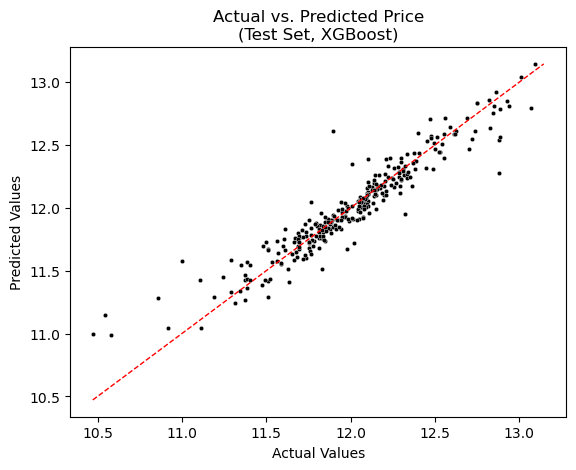

In [19]:
sns.scatterplot(x=y_test, y=y_hat_test, color="black", s=10)
min_val = min(min(y_test), min(y_hat_test))
max_val = max(max(y_test), max(y_hat_test))
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Price\n(Test Set, XGBoost)")
plt.show()

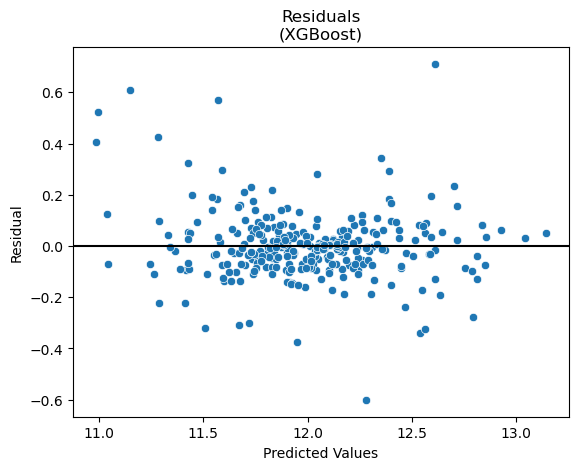

In [20]:
error_xgb = y_hat_test - y_test
sns.scatterplot(x=y_hat_test, y=error_xgb)
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals\n(XGBoost)')
plt.show()

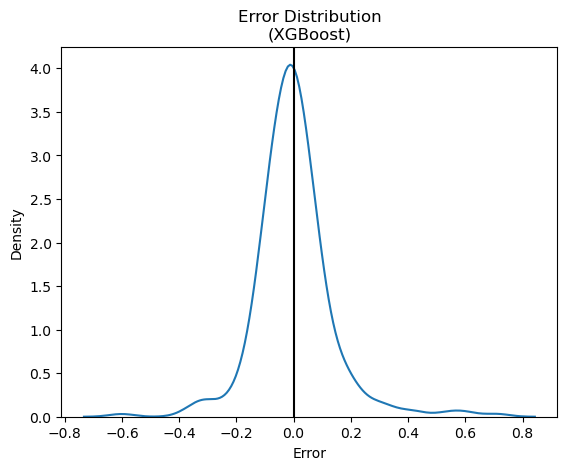

In [21]:
sns.kdeplot(error_xgb)
plt.axvline(x=0, color="black")
plt.xlabel('Error')
plt.ylabel('Density')
plt.title('Error Distribution\n(XGBoost)')
plt.show()

In [23]:
test = pd.read_csv("data/test.csv")

In [25]:
X_test_pub = pipeline.transform(test[features])

[IterativeImputer] Completing matrix with shape (1459, 303)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.01


In [31]:
predictions = pd.DataFrame({"Id": test["Id"], "SalePrice": xgb_best.predict(X_test_pub)})
predictions.assign(SalePrice=lambda df: np.expm1(df["SalePrice"]))

,Id,SalePrice
0,1461,121541.031250
1,1462,159720.031250
2,1463,183998.140625
3,1464,192630.859375
4,1465,194296.156250
...,...,...
1454,2915,85457.437500
1455,2916,79553.140625
1456,2917,149541.750000
1457,2918,112664.796875
